# Random network

## define functions

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import modules.lib_hopf_osc_sim as sim

def get_ER_connected_adjmatrix(N,P):
    while True:
        G = nx.fast_gnp_random_graph(N, P)
        if nx.is_connected(G):
            break
        else:
            print("Graph disconnected. Regenerating...")

    # 1. Adjacency Matrix (S_ij)
    A = nx.to_numpy_array(G, dtype=np.float64)
    return A,G


## simulate

In [7]:

save_simulation_output = False

# --- System Parameters (Global) ---
N     = 50           # Number of coupled elements (oscillators)
T     = 200.0        # Total simulation time
dt    = 0.01        # Time step (dt)
tau   = 2.0        # Constant delay (t_ij = tau for all i, j)
alpha = 0.1      # Noise intensity coefficient (alpha)
beta  = 0.1       # Overall coupling strength (beta)

omega_mean  = 5.0
omega_amp   = 0.01 * omega_mean
lambda_mean = 0.6
lambda_amp  = 0.1 * lambda_mean

# --- Network Parameters ---
P = 0.2          # Probability for Erdős-Rényi network (p)
k_avg = N * P    # Theoretical average degree

# --- Network Generation (Using NetworkX - OUTSIDE NUMBA) ---
print("Generating Connected Erdős-Rényi Network...")
A,G = get_ER_connected_adjmatrix(N,P)

# 2. Final Coupling Matrix K_ij = (beta / <k>) * A_ij
K_matrix = np.ascontiguousarray((beta / k_avg) * A)

# CRITICAL FIX: Cast the K matrix to complex type (complex128)
# to match the dtype of the Z_delayed vector inside the Numba function.
K_matrix_complex = K_matrix.astype(np.complex128)
K_matrix_ij = K_matrix_complex 

# --- Initial Conditions and Element Parameters ---
np.random.seed(42)
omega_i  = omega_mean + omega_amp * np.random.uniform(-1, 1, N)
lambda_i = lambda_mean + lambda_amp * np.random.uniform(-1, 1, N)
Complex_Param = (lambda_i - 1.0) + 1j * omega_i
Z_initial = (np.random.normal(0, 0.1, N) + 1j * np.random.normal(0, 0.1, N))


# --- Main Execution Block ---

print(f"\n--- Running ER Network SDDE Simulation ---")
print(f"N={N}, P={P} (Avg Degree={k_avg}), T={T}, tau={tau}")

# Run the accelerated integration function
Z = sim.integrate_Hopf_oscillators_const_delay(
    T, dt, alpha, N, T=tau / dt, a=Complex_Param,
    Z_initial=Z_initial, 
    J_R_C_coupling_matrix=K_matrix_ij # Pass the complex, weighted coupling matrix
)

print("Simulation finished (accelerated).")


if save_simulation_output:
    import scipy.io
    import modules.io as io
    scipy.io.savemat(io.get_new_file_name('oscillator_dynamics_FIG_PAPER.mat'),dict(Z=Z,N=N,T=T,
        dt=dt,
        tau=tau,
        alpha=alpha,
        beta=beta,
        omega_mean=omega_mean,
        omega_amp=omega_amp,
        lambda_mean=lambda_mean,
        lambda_amp=lambda_amp,
        A=A,
        P=P,
        k_avg=k_avg),do_compression=True,appendmat=True)

Generating Connected Erdős-Rényi Network...

--- Running ER Network SDDE Simulation ---
N=50, P=0.2 (Avg Degree=10.0), T=200.0, tau=2.0
Simulation finished (accelerated).


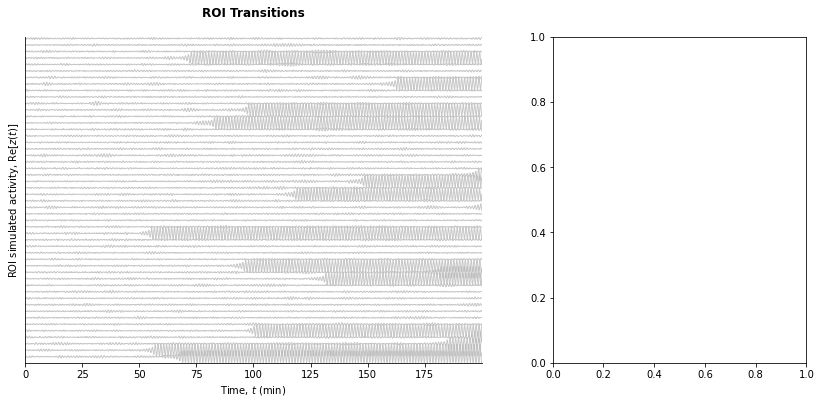

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1.8, 1]},facecolor='w')

# --- Panel A: Schematic Time Series (Stacked) ---
offset = 1.5  # Vertical spacing to make it look schematic
time_axis = np.arange(Z.shape[0])*dt
for i in np.arange(N):
    # Adding a vertical offset so traces don't overlap
    ax1.plot(time_axis, np.real(Z[:, i]) + (i * offset), 
             color='#bbbbbb', lw=1, alpha=0.8, label=f'Node {i}')
ax1.set_title('ROI Transitions', loc='center', fontweight='bold', pad=20)
ax1.set_xlabel('Time, $t$ (min)')
ax1.set_ylabel('ROI simulated activity, Re[$z(t)$]')
ax1.set_yticks([]) # Remove specific values for a schematic look
ax1.set_xlim(time_axis[0], time_axis[-1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.autoscale(tight=True)

plt.show()

## load saved data (if needed)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.io

d = scipy.io.loadmat('oscillator_dynamics_FIG_PAPER.mat',squeeze_me=True)

Z           = d['Z']
N           = d['N']
T           = d['T']
dt          = d['dt']
tau         = d['tau']
alpha       = d['alpha']
beta        = d['beta']
omega_mean  = d['omega_mean']
omega_amp   = d['omega_amp']
lambda_mean = d['lambda_mean']
lambda_amp  = d['lambda_amp']
A           = d['A']
P           = d['P']
k_avg       = d['k_avg']

## preliminary plot of simulation data

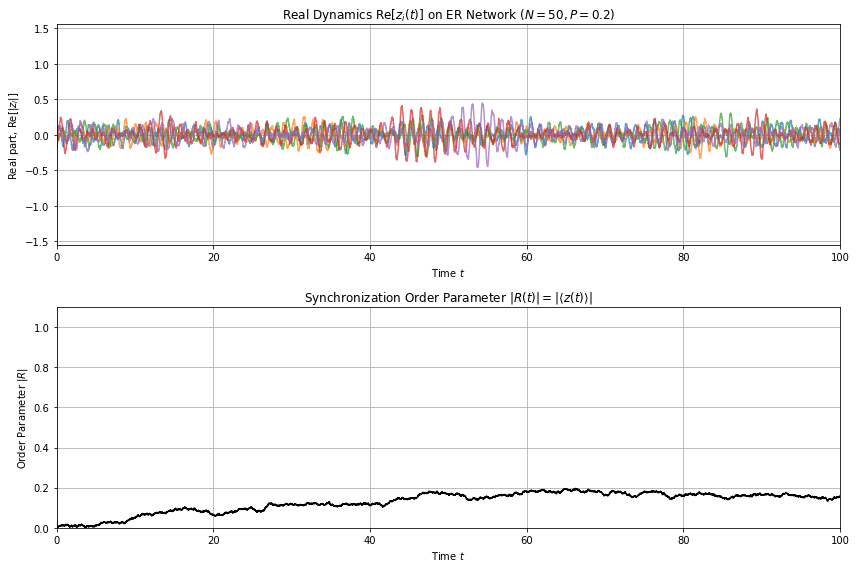

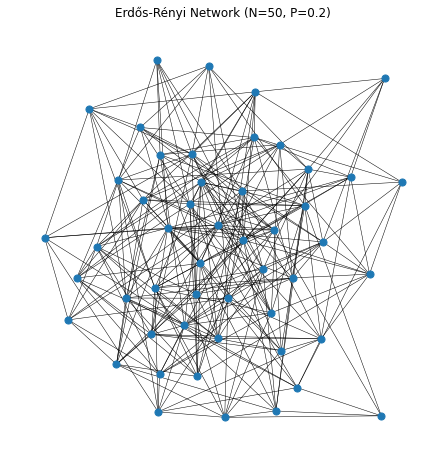

In [3]:



# --- Final Plotting Block ---
Nt = int(T / dt)
time_axis = np.linspace(0, T, Nt)

# Calculate the Order Parameter
R_t = np.mean(Z, axis=1)

# Create a single figure with two subplots
plt.figure(figsize=(12, 8))

xlim_range = (0,100)

# 1. Amplitude Dynamics
plt.subplot(2, 1, 1)
#plt.plot(time_axis, np.abs(Z[:, :5]), alpha=0.7)
#plt.title(f'Amplitude Dynamics $|z_i(t)|$ on ER Network ($N={N}, P={P}$)')
plt.plot(time_axis, np.real(Z[:, :5]), alpha=0.7)
plt.title(f'Real Dynamics Re[$z_i(t)$] on ER Network ($N={N}, P={P}$)')
plt.xlabel('Time $t$')
#plt.ylabel('Amplitude $|z_i|$')
plt.ylabel('Real part, Re[$|z_i|$]')
plt.xlim(xlim_range)
plt.grid(True)

# 2. Global Order Parameter (Synchronization)
plt.subplot(2, 1, 2)
plt.plot(time_axis, np.abs(R_t), color='black')
plt.title('Synchronization Order Parameter $|R(t)| = |\\langle z(t) \\rangle|$')
plt.xlabel('Time $t$')
plt.ylabel('Order Parameter $|R|$')
plt.xlim(xlim_range)
plt.ylim(0, 1.1)
plt.grid(True)

plt.tight_layout()
plt.show() # Only call show once to display both plots together

if G:
    # Final step: Also visualize the network used
    plt.figure(figsize=(6, 6))
    nx.draw(G, node_size=50, width=0.5)
    plt.title(f'Erdős-Rényi Network (N={N}, P={P})')

plt.show()

## oscillator signal and cycle

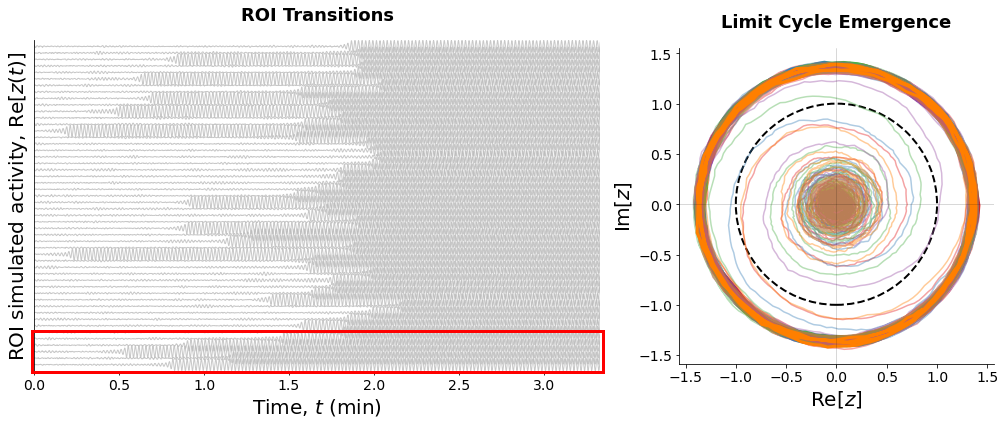

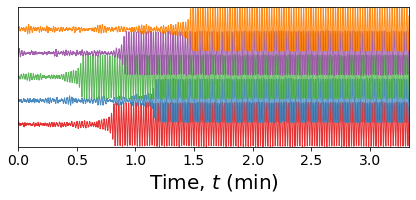

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_rectangle(ax, x0, y0, x1, y1, **kwargs):
    """
    Plot a rectangle on the given axes using two opposite corners
    specified in data coordinates.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes to draw on.
    x0, y0 : float
        Coordinates of the first corner.
    x1, y1 : float
        Coordinates of the opposite corner.
    kwargs : dict
        Additional keyword arguments passed to patches.Rectangle
        (e.g., edgecolor='red', facecolor='none', linewidth=2).
    """
    # Compute lower-left corner and width/height
    x_min, x_max = sorted([x0, x1])
    y_min, y_max = sorted([y0, y1])
    width = x_max - x_min
    height = y_max - y_min
    rect = patches.Rectangle(
        (x_min, y_min),
        width,
        height,
        **kwargs
    )
    ax.add_patch(rect)
    return rect

# --- High-Visibility Formatting ---
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 20,
    'axes.titlesize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12,
    'font.family': 'sans-serif' # Sans-serif is often cleaner for schematics
})

Nt = int(T / dt)
time_axis = np.linspace(0, T, Nt) / 60.0

# Select first 5 nodes
indices      = np.arange(5)
indices_all  = np.arange(N) #np.asarray(list(set(range(N)) - set(indices)))
colors = ['#E63946', '#457B9D', '#1D3557', '#06D6A0', '#F1FAEE'] # High contrast palette
# (Or use a standard bold map)
colors = plt.cm.Set1(np.linspace(0, 0.5, 5))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1.8, 1]},facecolor='w')

# --- Panel A: Schematic Time Series (Stacked) ---
offset = 1.5  # Vertical spacing to make it look schematic
for i in indices_all:
    # Adding a vertical offset so traces don't overlap
    ax1.plot(time_axis, np.real(Z[:, i]) + (i * offset), 
             color='#bbbbbb', lw=1, alpha=0.8, label=f'Node {i}')
ax1.set_title('ROI Transitions', loc='center', fontweight='bold', pad=20)
ax1.set_xlabel('Time, $t$ (min)')
ax1.set_ylabel('ROI simulated activity, Re[$z(t)$]')
ax1.set_yticks([]) # Remove specific values for a schematic look
ax1.set_xlim(time_axis[0], time_axis[-1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.autoscale(tight=True)

yeps = 0.12
xeps = 0.01
plot_rectangle(ax1,ax1.get_xlim()[0]-xeps*offset,ax1.get_ylim()[0]-yeps*offset,ax1.get_xlim()[1]+xeps*offset,indices[-1]*offset+(1+yeps)*offset,
               edgecolor='r', facecolor='none', lw=3, zorder=100, clip_on=False)

# --- Panel B: Schematic Phase Space ---
for i in indices:
    # Plot only the last portion of the data to emphasize the circle
    # but keep some "tail" to show the approach
    ax2.plot(np.real(Z[:, i]), np.imag(Z[:, i]), 
             color=colors[i], lw=1.5, alpha=0.4)
    
    # Draw the final stable limit cycle bolder
    ax2.plot(np.real(Z[-500:, i]), np.imag(Z[-500:, i]), 
             color=colors[i], lw=3, alpha=1)

circle = plt.Circle((0, 0), 1.0, 
                    color='k',      # Line/fill color
                    fill=False,        # Make it an outline
                    linestyle='--',    # Dashed line
                    linewidth=2)       # Line thickness

# 3. Add the patch to the axes
ax2.add_patch(circle)

# Draw a "Zero" crosshair for schematic reference
ax2.axhline(0, color='black', lw=0.5, alpha=0.3)
ax2.axvline(0, color='black', lw=0.5, alpha=0.3)

ax2.set_title('Limit Cycle Emergence', loc='center', fontweight='bold', pad=20)
ax2.set_xlabel('Re[$z$]')
ax2.set_ylabel('Im[$z$]')
ax2.set_aspect('equal')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

fig.tight_layout()


figin, ax_in = plt.subplots(1, 1, figsize=(6, 3))
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12,
    'font.family': 'sans-serif' # Sans-serif is often cleaner for schematics
})

for i in indices:
    # Adding a vertical offset so traces don't overlap
    ax_in.plot(time_axis, np.real(Z[:, i]) + (i * offset), 
             color=colors[i], lw=1.0, alpha=0.9, label=f'Node {i}')

ax_in.autoscale(tight=True)
ax_in.set_yticks([])
ax_in.set_xlabel('Time, $t$ (min)')

figin.tight_layout()


fig.savefig('D:/Dropbox/p/ufsc/artigos/sync_epilepsia_debona/figs/sim_transitions_cycle.png',dpi=400,bbox_inches='tight')
figin.savefig('D:/Dropbox/p/ufsc/artigos/sync_epilepsia_debona/figs/sim_transitions_cycle_inset.png',dpi=400,bbox_inches='tight')

plt.show()

## sync figure

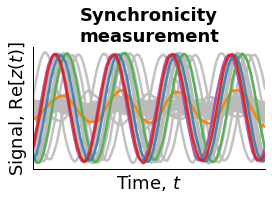

In [240]:
import numpy as np
import matplotlib.pyplot as plt

# --- High-Visibility Formatting ---
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12,
    'font.family': 'sans-serif' # Sans-serif is often cleaner for schematics
})

Nt        = int(T / dt)
time_axis = np.linspace(0, T, Nt)

t1 = 80.0
t2 = t1+5.0
tind = np.where((time_axis>t1) & (time_axis <t2))[0]

# Select first 5 nodes
indices = np.arange(N)
colors  = ['#E63946', '#457B9D', '#1D3557', '#06D6A0', '#F1FAEE'] # High contrast palette
# (Or use a standard bold map)
colors = plt.cm.Set1(np.linspace(0, 0.5, 5))

fig, ax1 = plt.subplots(1, 1, figsize=(4, 3),facecolor='w')

for i in indices[::-1]:
    # Adding a vertical offset so traces don't overlap
    c = colors[i] if i < 5 else '#bbbbbb'
    ax1.plot(time_axis[tind], np.real(Z[tind, i]), 
             color=c, lw=2.5, alpha=0.9, label=f'Node {i}')

ax1.set_title('Synchronicity\nmeasurement', loc='center', fontweight='bold', pad=5)
ax1.set_xlabel('Time, $t$')
ax1.set_ylabel('Signal, Re[$z(t)$]')
#ax1.set_ylabel('ROI\nsimulated\nactivity')
ax1.set_xticks([]) # Remove specific values for a schematic look
ax1.set_yticks([]) # Remove specific values for a schematic look
ax1.set_xlim(time_axis[tind[0]], time_axis[tind[-1]])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

fig.tight_layout()

plt.savefig('D:/Dropbox/p/ufsc/artigos/sync_epilepsia_debona/figs/sim_signal_time.png',dpi=400,bbox_inches='tight')

plt.show()

## amplitude figure

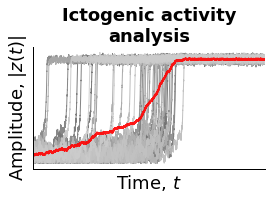

In [241]:
import numpy as np
import matplotlib.pyplot as plt

# --- High-Visibility Formatting ---
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12,
    'font.family': 'sans-serif' # Sans-serif is often cleaner for schematics
})

Nt        = int(T / dt)
time_axis = np.linspace(0, T, Nt)

R_t = np.mean(np.abs(Z), axis=1)

#t1 = 0.0
#t2 = t1+100.0
#tind = np.where((time_axis>t1) & (time_axis <t2))[0]

# Select first 5 nodes
indices = np.arange(N)
#colors  = ['#E63946', '#457B9D', '#1D3557', '#06D6A0', '#F1FAEE'] # High contrast palette
# (Or use a standard bold map)
colors = plt.get_cmap('gray')(np.linspace(0.8,0.4,N)) #plt.cm.Set1(np.linspace(0, 0.5, 5))

fig, ax1 = plt.subplots(1, 1, figsize=(4, 3),facecolor='w')

for i in indices[::-1]:
    # Adding a vertical offset so traces don't overlap
    c = colors[i,:]
    ax1.plot(time_axis, np.abs(Z[:, i]), 
             color=c, lw=1, alpha=0.9, label=f'Node {i}')

ax1.plot(time_axis, R_t, 
            color='r', lw=2, alpha=0.9, label=f'Node {i}')


ax1.set_title('Ictogenic activity\nanalysis', loc='center', fontweight='bold', pad=5)
ax1.set_xlabel('Time, $t$')
ax1.set_ylabel('Amplitude, $|z(t)|$')
#ax1.set_ylabel('ROI\nsimulated\nactivity')
ax1.set_xticks([]) # Remove specific values for a schematic look
ax1.set_yticks([]) # Remove specific values for a schematic look
ax1.set_xlim(time_axis[0], time_axis[-1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

fig.tight_layout()

plt.savefig('D:/Dropbox/p/ufsc/artigos/sync_epilepsia_debona/figs/sim_amplitude_time.png',dpi=400,bbox_inches='tight')

plt.show()

## ROI ALFF signal

<ipython-input-2-4ddd21499991>:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


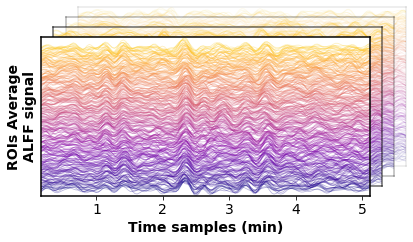

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12,
    'font.family': 'sans-serif' # Sans-serif is often cleaner for schematics
})

# --- The function provided by you ---
def plot_fmri_stack_on_axis(ax, data, n_subset=306, time_window=None, 
                            offset=0.8, smooth_factor=3, cmap_name='plasma', lw=0.4, alpha=0.3):
    total_time = (5.0*60.0 + 9.0) / 60.0 # minutes
    dt = total_time / 150.0

    if time_window is None:
        time_window = (0, data.shape[0])
    if n_subset is None:
        n_subset = data.shape[1]
    
    indices = np.linspace(0, data.shape[1] - 1, n_subset, dtype=int)
    subset = data[time_window[0]:time_window[1], indices]
    
    subset_norm = (subset - np.mean(subset, axis=0)) / (np.std(subset, axis=0) + 1e-8)
    
    if n_subset > 100:
        lw = 0.4 if lw is None else lw
        alpha = 0.3 if alpha is None else alpha
    else:
        lw = 1.5 if lw is None else lw
        alpha = 0.8 if alpha is None else alpha

    time_axis = np.arange(150)[5:][time_window[0]:time_window[1]] * dt
    colors = plt.get_cmap(cmap_name)(np.linspace(0, 0.9, n_subset))

    for i in range(n_subset):
        y = subset_norm[:, i]
        if smooth_factor > 1:
            y = np.convolve(y, np.ones(smooth_factor)/smooth_factor, mode='same')
        
        ax.plot(time_axis, y + (i * offset), 
                color=colors[i], lw=lw, alpha=alpha, antialiased=True)

    ax.autoscale(tight=True)
    ax.set_xlim(time_axis[0], time_axis[-1])
    #ax.set_ylabel(f'ROIs Average\nALFF signal', fontweight='bold', fontsize=10)
    ax.set_yticks([])
    #ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_linewidth(1.5)
    
    return ax

# --- Code to create the Pile ---
dir_path  = 'D:/Dropbox/p/pesquisa/epilepsy_criticality/tle_matrix/rsfMRI_timeseries'
file_paths = ['rsFMRI_307_2.mat', 'rsFMRI_301_1.mat', 'rsFMRI_304_1.mat', 'rsFMRI_306_1.mat']
n_files = len(file_paths)

fig = plt.figure(figsize=(12, 10),facecolor='w')

# Settings for the "pile" geometry
# dx, dy control the 'staircase' shift towards the top-right
dx = 0.014 
dy = 0.014
width, height = 0.38, 0.22

# We iterate from last to first (n-1 down to 0) 
# This ensures file1 (index 0) is drawn LAST and stays on TOP of the pile
alpha_ax = np.linspace(1.0,0.3,n_files)
for i in range(n_files - 1, -1, -1):
    # Calculate the shift for this "sheet"
    # i=0 (top) will be at [0.1, 0.1]
    # i=3 (bottom) will be at [0.1 + 3*dx, 0.1 + 3*dy]
    rect = [0.1 + i*dx, 0.1 + i*dy, width, height]
    
    # Create the axis with an opaque white background
    ax = fig.add_axes(rect, facecolor=(1,1,1,alpha_ax[i]))
    
    # Add a full border to make it look like a physical sheet
    for spine in ax.spines.values():
        spine.set_edgecolor((0,0,0,alpha_ax[i]))
        spine.set_linewidth(1.5)

    try:
        # Loading your specific variable
        mat_data = loadmat(os.path.join(dir_path,file_paths[i]))['timeseries_rsfmri']
        
        # Use your function to populate the sheet
        plot_fmri_stack_on_axis(ax, mat_data, n_subset=306, offset=0.2, lw=0.8, smooth_factor=0)
        for artist in ax.get_children():
            if hasattr(artist, "get_alpha") and hasattr(artist, "set_alpha"):
                current_alpha=1.0
                current_alpha = av if (av := artist.get_alpha()) is not None else alpha_ax[i]
                artist.set_alpha(current_alpha*alpha_ax[i])
        if i > 0:
            ax.set_xticks([])
        # Label each sheet
        #ax.text(0.98, 0.95, f'Subject {i+1}', transform=ax.transAxes, 
        #        ha='right', va='top', fontweight='bold', fontsize=12)
                
    except Exception as e:
        ax.text(0.5, 0.5, f"Data {i+1} Missing", ha='center', va='center')

# Final layout refinements
ax.set_xlabel('Time samples (min)', fontweight='bold', fontsize=14)
ax.set_ylabel(f'ROIs Average\nALFF signal', fontweight='bold', fontsize=14)
plt.subplots_adjust(hspace=0.1) # Tight vertical stacking

fig.tight_layout()

plt.savefig('D:/Dropbox/p/ufsc/artigos/sync_epilepsia_debona/figs/ROI_ALFF_signal.png',dpi=400,bbox_inches='tight')

plt.show()

# Mean-field

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import complex128, float64, int64, njit

@njit(complex128[:](complex128[:], complex128[:]))
def f_numba(z, Complex_Param_i):
    """The local dynamics function f(z_i) for complex z."""
    abs_sq = np.abs(z)**2 # |z_i|^2
    abs_quad = abs_sq**2  # |z_i|^4
    
    # f(z_i) = (Complex_Param_i) * z_i + 2 z_i |z_i|^2 - z_i |z_i|^4
    return Complex_Param_i * z + 2 * z * abs_sq - z * abs_quad

@njit(
    # Full signature for Numba's type checking
    complex128[:,:](
        float64, float64, float64, int64, float64, float64,
        complex128[:], complex128[:]
    )
)
def integrate_Hopf_oscillators(
    T, dt, alpha, N, delay_steps_float, coupling_weight,
    Z_initial, Complex_Param_i
):
    # --- Pre-calculations inside the function (Type safety for Numba) ---
    
    # CRITICAL FIX 1: Explicitly cast shape calculation results to int64
    Nt = int64(T / dt)
    delay_steps = int64(delay_steps_float)
    buffer_size = delay_steps + 1
    
    sqrt_dt_complex_noise = np.sqrt(dt / 2.0)
    
    # Initialize main state array (Z, Nt and N are int64)
    Z = np.zeros((Nt, N), dtype=np.complex128)
    Z[0, :] = Z_initial

    # CRITICAL FIX 2: Replace unsupported np.tile with Numba-compatible loop
    # 1. Create the history buffer initialized with zeros (buffer_size and N are int64)
    history_buffer = np.zeros((buffer_size, N), dtype=np.complex128)
    
    # 2. Fill every row with the initial condition
    for i in range(buffer_size):
        history_buffer[i, :] = Z_initial
        
    history_index = 0

    # --- Simulation Loop (Complex Euler-Maruyama Method) ---
    for t in range(Nt - 1):
        # 1. Get Delayed Value z_j(t - tau)
        Z_delayed = history_buffer[history_index, :]

        # Current state z_i(t)
        Z_current = Z[t, :]

        # 2. Calculate the Coupling Term D(t)
        sum_Z_delayed = np.sum(Z_delayed)
        coupling_sum_z_j = sum_Z_delayed - Z_delayed
        coupling_term = coupling_weight * (coupling_sum_z_j - (N - 1) * Z_current)
        
        # 3. Calculate the Drift Term G(t)
        drift_term = f_numba(Z_current, Complex_Param_i) + coupling_term

        # 4. Calculate the Noise Term (dW_i)
        dW_R = np.random.normal(0.0, 1.0, N) * sqrt_dt_complex_noise 
        dW_I = np.random.normal(0.0, 1.0, N) * sqrt_dt_complex_noise
        dW_complex = dW_R + 1j * dW_I
        noise_term = alpha * dW_complex
        
        # 5. Euler-Maruyama Step
        Z[t + 1, :] = Z_current + drift_term * dt + noise_term

        # 6. Update History Buffer (Ring Buffer)
        history_index = (history_index + 1) % buffer_size
        history_buffer[history_index, :] = Z[t + 1, :]
        
    return Z


Preparing to run Numba-accelerated simulation (N=50, T=200.0)...
Simulation finished (accelerated).


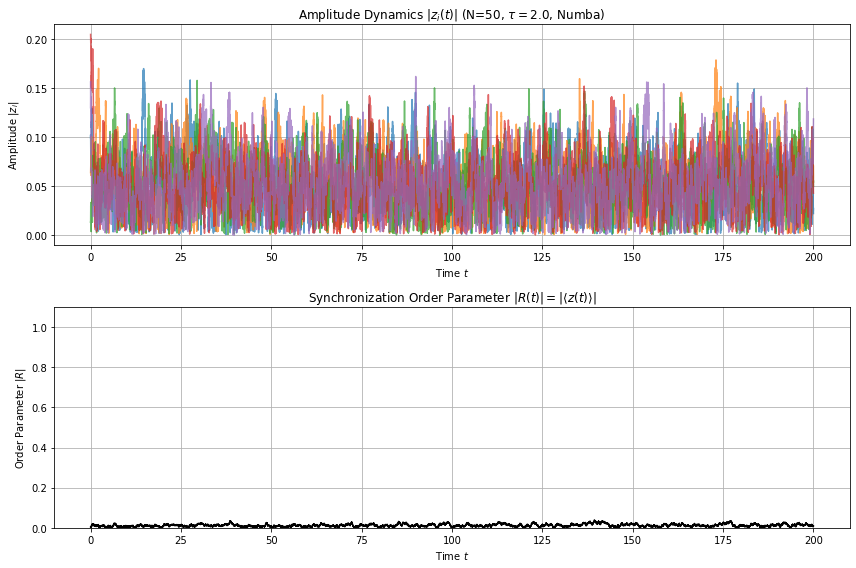

In [ ]:

# --- System Parameters (Global) ---
N = 50           # Number of coupled elements (oscillators)
T = 200.0        # Total simulation time
dt = 0.01        # Time step (dt)
tau = 2.0        # Constant delay (t_ij = tau for all i, j)
alpha = 0.1      # Noise intensity coefficient (alpha)
beta = 1.0       # Coupling strength coefficient (beta)

# --- Individual Element Parameters (Heterogeneous) ---
np.random.seed(42)

mean_omega = 1.0
omega_i = mean_omega + 0.1 * np.random.uniform(-1, 1, N)

mean_lambda = 0.5
lambda_i = mean_lambda + 0.05 * np.random.uniform(-1, 1, N)

# Complex parameter array for the linear term: (lambda_i - 1 + i * omega_i)
Complex_Param = (lambda_i - 1.0) + 1j * omega_i


# --- Main Execution Block ---

print(f"Preparing to run Numba-accelerated simulation (N={N}, T={T})...")

# Pre-calculate and prepare parameters for the Numba function call
coupling_weight = beta / (N - 1)
delay_steps_float = tau / dt # Pass this float value to Numba

# Initial condition
Z_initial = (np.random.normal(0, 0.1, N) + 1j * np.random.normal(0, 0.1, N))

# Run the accelerated integration function
Z = integrate_Hopf_oscillators(
    T, dt, alpha, N, delay_steps_float, coupling_weight,
    Z_initial, Complex_Param
)

print("Simulation finished (accelerated).")

# --- Plotting the Results ---
Nt = int(T / dt) # Use standard Python int for plotting
time_axis = np.linspace(0, T, Nt)

plt.figure(figsize=(12, 8))

# 1. Amplitude Dynamics
plt.subplot(2, 1, 1)
plt.plot(time_axis, np.abs(Z[:, :5]), alpha=0.7)
plt.title(f'Amplitude Dynamics $|z_i(t)|$ (N={N}, $\\tau={tau}$, Numba)')
plt.xlabel('Time $t$')
plt.ylabel('Amplitude $|z_i|$')
plt.grid(True)

# 2. Global Order Parameter
R_t = np.mean(Z, axis=1)
plt.subplot(2, 1, 2)
plt.plot(time_axis, np.abs(R_t), color='black')
plt.title('Synchronization Order Parameter $|R(t)| = |\\langle z(t) \\rangle|$')
plt.xlabel('Time $t$')
plt.ylabel('Order Parameter $|R|$')
plt.ylim(0, 1.1)
plt.grid(True)

plt.tight_layout()
plt.show()